# IDEA:
**Reservoir:**
- Fix everything apart from W_out
- Train the reservoir two times for two different dynamical systems (with the same dimensions)
- save the w_outs
- Reinitialize the reservoir and choose a w_out -> let it run, see what comes results
- Drive it with one and see what comes out with the other:

**Autonomous Reservoir:**
$$r_{i+1} = f(W r_i + W_{in} u_i) = f(W r_i + W_{in} W_{out} g(r_i))$$

# Imports:

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 7)
from sklearn import decomposition

import rescomp

### Lorenz iterator:

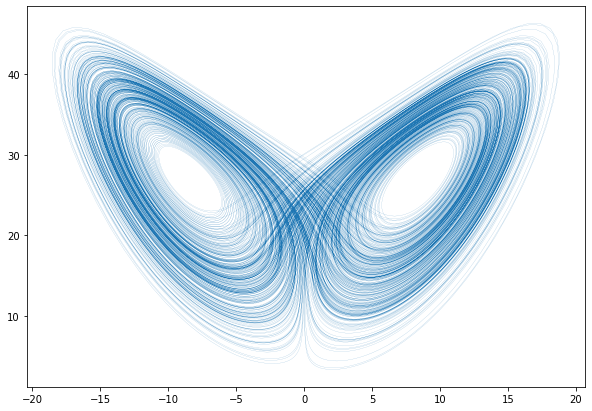

In [3]:
# Lorenz parameters:
dt_L = 0.01
lyap_L = 0.934
starting_point_L = np.array([0, 1, 0])
# starting_point_L = np.array([-14.03020521, -20.88693127, 25.53545])

# lorenz iterator:
def data_creation_function_L(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function_L(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 50000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series_L = time_series_all[disc_steps:, :]

plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1)

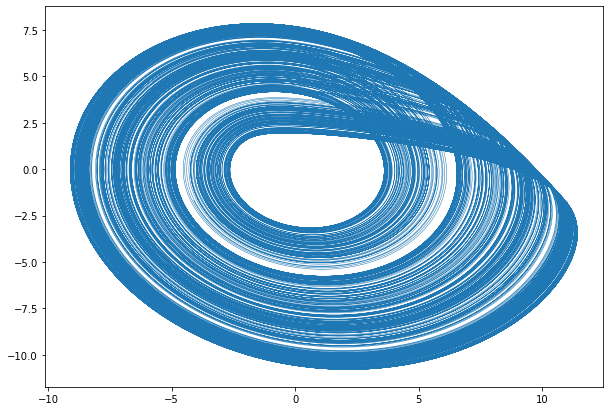

In [4]:
# Roessler parameters:
dt_R = 0.05
lyap_R = 1
starting_point_R = np.array([0, 1, 0])

# Roessler iterator:
def data_creation_function_R(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("roessler_sprott", dt, time_steps, starting_point)

def f_R(x):
    return data_creation_function_R(2, dt_R, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 50000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_R

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_R(x_last)

time_series_R = time_series_all[disc_steps:, :]

plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.5)

# Create the ESN architecture:

In [5]:
esn = rescomp.ESNWrapper()
esn.set_console_logger("debug")
esn.create_architecture(500, 3, w_out=np.random.randn(3, 500), seed=10, w_out_fit_flag="simple", leak_fct=0.0, activation_function="sigmoid")
esn.summary()

03-07 11:05:43 [DEBUG  ] Create network
03-07 11:05:43 [DEBUG  ] Create w_in
03-07 11:05:43 [DEBUG  ] Set activation function to flag: sigmoid
03-07 11:05:43 [DEBUG  ] _w_out_fit_flag set to simple
03-07 11:05:43 [DEBUG  ] Setting self._w_out with the set_w_out function
03-07 11:05:43 [DEBUG  ] ESN can run in loop
INPUT: 
x_dim: 3
INPUT-RESERVOIR COUPLING W_in: 
W_in: (500, 3)
- - - - - - - - - - -
w_in_scale: 1.0, w_in_sparse: True, w_in_ordered: False
RESERVOIR: 
- - - - - - - - - - -
Network: 
n_dim: 500
n_rad: 0.1, n_avg_deg: 6.0, n_type_flag: erdos_renyi, 
- - - - - - - - - - -
Dynamics: 
act_fct_flag: sigmoid, bias_scale: 0, leak_factor: 0.0
Update equation: r(i+1) = leak_fct * r(i) + (1-leak_fct) * act_fct(W_in * x(i) + W * r(i))
NON-LINEAR TRANSFORM OF RESERVOIR STATE: 
w_out_fit_flag: simple
RESERVOIR-OUTPUT COUPLING W_out: 
W_out: (3, 500)



# Train for Lorenz system:

03-07 11:05:43 [DEBUG  ] Start syncing the reservoir state
03-07 11:05:43 [DEBUG  ] Start training
03-07 11:05:43 [DEBUG  ] Start syncing the reservoir state
03-07 11:05:44 [DEBUG  ] Fit _w_out according to method 0
03-07 11:05:44 [DEBUG  ] Start Prediction
(3, 500)


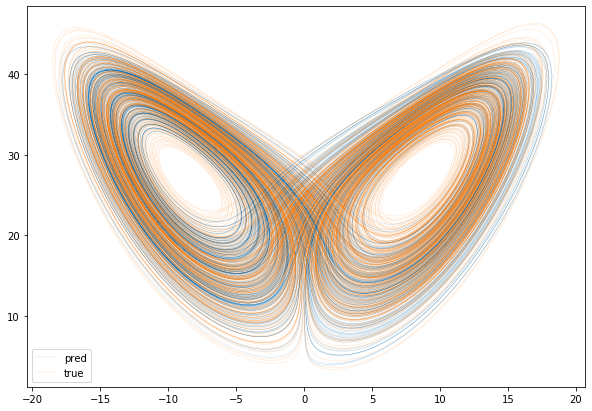

In [6]:
esn.reset_res_state()
train_steps = 10000
sync_steps = 100
esn.train(x_train=time_series_L[:sync_steps + train_steps], sync_steps=sync_steps, reg_param=0.0001, w_in_no_update=True)
y_pred_L0, y_test_L0 = esn.predict(time_series_L[sync_steps + train_steps-1:], save_r=True)
r_L = esn._r_pred.copy()
w_out_L = esn.get_w_out()
print(w_out_L.shape)
plt.plot(y_pred_L0[:, 0], y_pred_L0[:, 2], linewidth=0.1, label="pred")
plt.plot(y_test_L0[:, 0], y_test_L0[:, 2], linewidth=0.1, label="true")
plt.legend()

# Train for Roessler System:

03-07 11:05:50 [DEBUG  ] Start syncing the reservoir state
03-07 11:05:50 [DEBUG  ] Start training
03-07 11:05:50 [DEBUG  ] Start syncing the reservoir state
03-07 11:05:51 [DEBUG  ] Fit _w_out according to method 0
03-07 11:05:51 [DEBUG  ] Start Prediction
(3, 500)


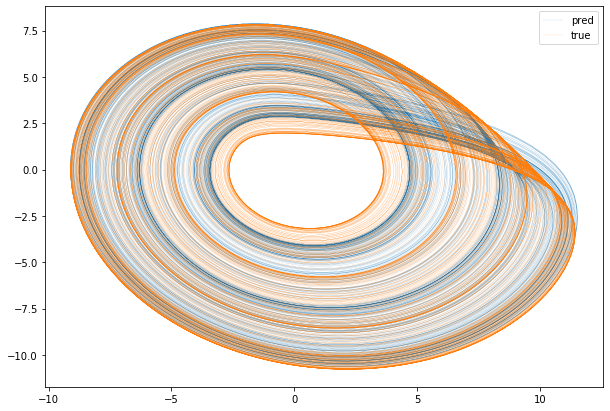

In [7]:
esn.reset_res_state()
train_steps = 10000
sync_steps = 100
esn.train(x_train=time_series_R[:sync_steps + train_steps], sync_steps=sync_steps, reg_param=0.0001, w_in_no_update=True)
y_pred_R0, y_test_R0 = esn.predict(time_series_R[sync_steps + train_steps-1:], save_r=True)
r_R = esn._r_pred.copy()
w_out_R = esn.get_w_out()
print(w_out_R.shape)
plt.plot(y_pred_R0[:, 0], y_pred_R0[:, 1], linewidth=0.1, label="pred")
plt.plot(y_test_R0[:, 0], y_test_R0[:, 1], linewidth=0.1, label="true")
plt.legend()

# Set random starting reservoir state:

In [8]:
np.random.seed(7)
initial_res_state = np.random.randn(500)*100
# initial_res_state = np.ones(500)

03-07 11:05:57 [DEBUG  ] Setting self._w_out with the set_w_out function


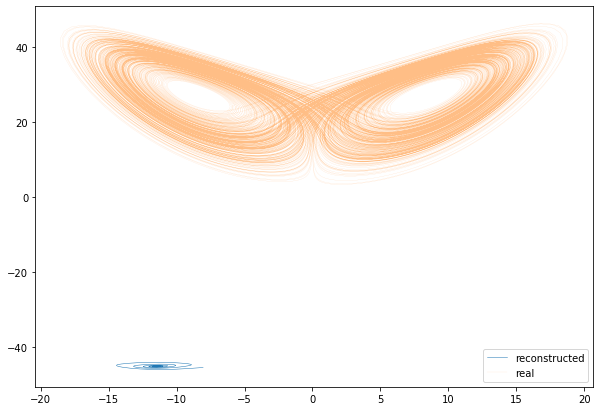

In [9]:
# Lorenz:
esn.reset_res_state(initial_res_state)
# esn.reset_res_state(r_R[-1, :])
esn.set_w_out(w_out_L)
y_pred = esn.run_loop(5000, save_r=True)[100:]
r_L_auto = esn._r_pred.copy()
plt.plot(y_pred[:, 0], y_pred[:, 2], linewidth=0.5, label="reconstructed")
plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1, label="real", alpha=0.5)
plt.legend()

03-07 11:05:58 [DEBUG  ] Setting self._w_out with the set_w_out function


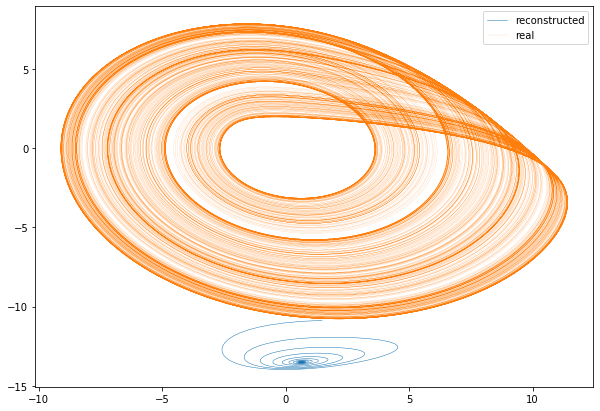

In [10]:
# Roessler:
esn.reset_res_state(initial_res_state)
# esn.reset_res_state(r_L[10, :])
# esn.synchronize(time_series_R[:1000, :])
esn.set_w_out(w_out_R)
y_pred_R = esn.run_loop(5000, save_r=True)[100:]
r_R_auto = esn._r_pred.copy()
plt.plot(y_pred_R[:, 0], y_pred_R[:, 1], linewidth=0.5, label="reconstructed")
plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.1, label="real")
plt.legend()

# PCA on both attractor manifolds:

In [267]:
print(r_L.shape)
print(r_R.shape)

R = np.concatenate((r_L, r_R))
# Both:

pca = decomposition.PCA(n_components=2)
pca.fit(R)
X = pca.transform(R)

(39900, 500)
(39900, 500)


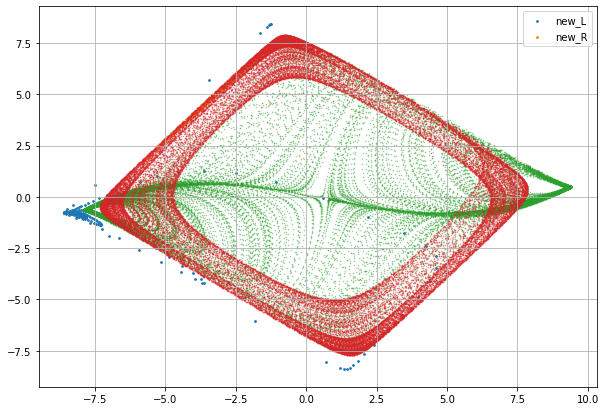

In [296]:
X_new_L = pca.transform(r_L_auto)
X_new_R = pca.transform(r_R_auto)

plt.scatter(X_new_L[:, 0], X_new_L[:, 1], s=3, label="new_L")
plt.scatter(X_new_R[:, 0], X_new_R[:, 1], s=3, label="new_R")

# Both:
plt.scatter(X[:39900, 0], X[:39900, 1], s=0.25, alpha=0.5) # L
plt.scatter(X[39900:, 0], X[39900:, 1], s=0.25, alpha=0.5) # R
plt.legend()
plt.grid()

# Pick a PCA Point and see the attractor:

In [308]:
point = np.array([10, 10]).reshape((2,1)).T
initial_res_state_new = pca.inverse_transform(point)[0, :]

In [309]:
initial_res_state_new.shape

(500,)

03-06 20:38:29 [DEBUG  ] Setting self._w_out with the set_w_out function


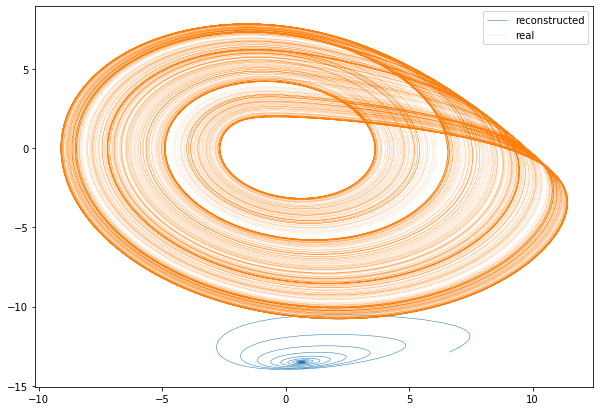

In [310]:
# Roessler:
esn.reset_res_state(initial_res_state_new)
esn.set_w_out(w_out_R)
y_pred_R = esn.run_loop(5000, save_r=True)[100:]
r_R_auto = esn._r_pred.copy()
plt.plot(y_pred_R[:, 0], y_pred_R[:, 1], linewidth=0.5, label="reconstructed")
plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.1, label="real")
plt.legend()

03-06 20:38:37 [DEBUG  ] Setting self._w_out with the set_w_out function


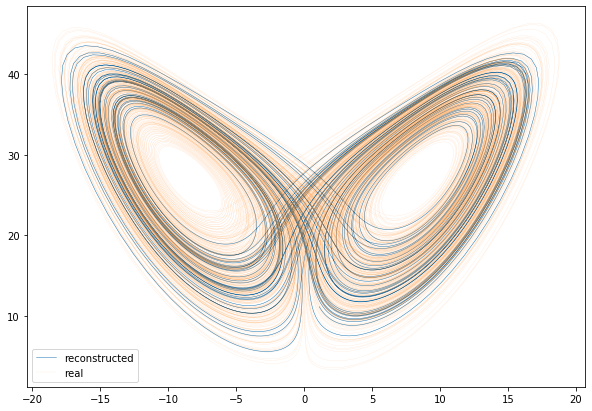

In [311]:
# Lorenz:
esn.reset_res_state(initial_res_state_new)
esn.set_w_out(w_out_L)
y_pred = esn.run_loop(5000, save_r=True)[100:]
r_L_auto = esn._r_pred.copy()
plt.plot(y_pred[:, 0], y_pred[:, 2], linewidth=0.5, label="reconstructed")
plt.plot(time_series_L[:, 0], time_series_L[:, 2], linewidth=0.1, label="real", alpha=0.5)
plt.legend()

# Drive with wrong system:

03-07 11:24:34 [DEBUG  ] Start syncing the reservoir state
03-07 11:24:34 [DEBUG  ] Setting self._w_out with the set_w_out function


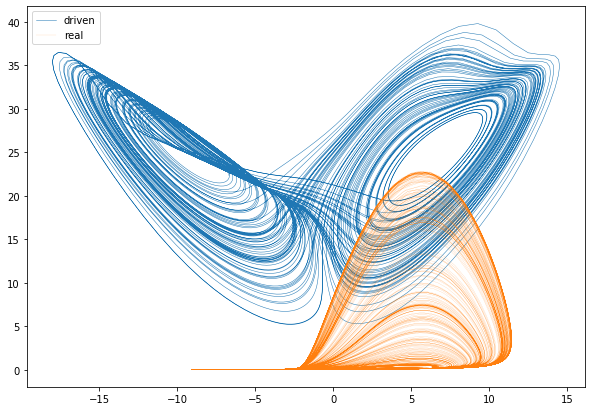

In [17]:
# Drive Roessler RC with Lorenz timeseries
esn.reset_res_state(initial_res_state)
esn.synchronize(time_series_L[:1000, :])
esn.set_w_out(w_out_R)
steps = 10000
y_pred_driven = np.zeros((steps, 3))
for t in range(steps):
    y_pred_driven[t, :] = esn._predict_step(time_series_L[t, :])

plt.plot(y_pred_driven[:, 0], y_pred_driven[:, 2], linewidth=0.5, label="driven")
plt.plot(time_series_R[:, 0], time_series_R[:, 2], linewidth=0.1, label="real")
plt.legend()

03-07 11:26:48 [DEBUG  ] Start syncing the reservoir state
03-07 11:26:48 [DEBUG  ] Setting self._w_out with the set_w_out function


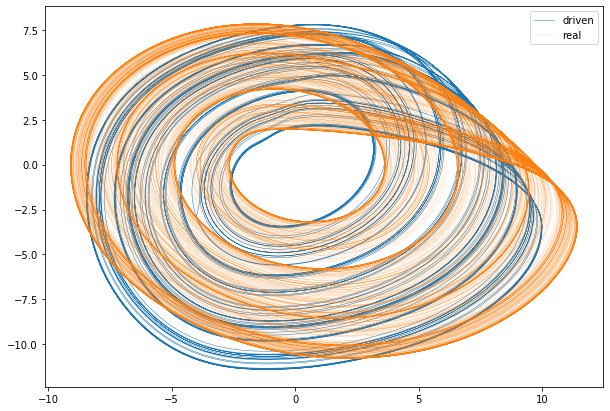

In [22]:
# Drive Lorenz RC with Roessler timeseries
esn.reset_res_state(initial_res_state)
esn.synchronize(time_series_R[:1000, :])
esn.set_w_out(w_out_L)
steps = 10000
y_pred_driven = np.zeros((steps, 3))
for t in range(steps):
    y_pred_driven[t, :] = esn._predict_step(time_series_R[t, :])

plt.plot(y_pred_driven[:, 0], y_pred_driven[:, 1], linewidth=0.5, label="driven")
plt.plot(time_series_R[:, 0], time_series_R[:, 1], linewidth=0.1, label="real")
plt.legend()

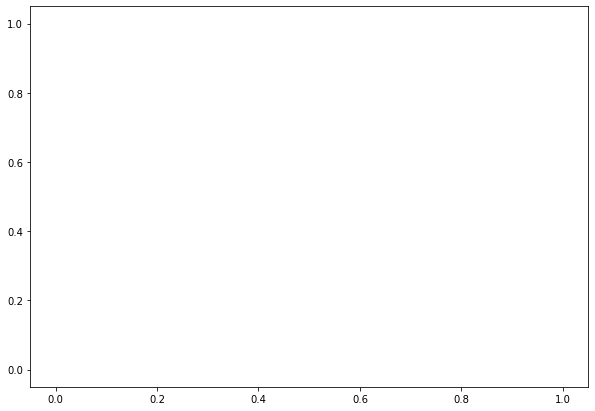

In [250]:
def plot_pca(r_L, r_R):
    R = np.concatenate((r_L, r_R))
    pca = decomposition.PCA(n_components=2)
    pca.fit(R)
    X = pca.transform(R)
    # Both:
    half = int(X.shape[0])
    plt.scatter(X[:half, 0], X[:half, 1], s=0.25, alpha=0.5)
    plt.scatter(X[half:, 0], X[half:, 1], s=0.25, alpha=0.5)

plot_pca(r_L_auto, r_R_auto)

In [251]:
r_R_auto

array([[3.77892293e-288, 0.00000000e+000, 1.00000000e+000, ...,
        1.00000000e+000, 0.00000000e+000, 1.21345084e-164],
       [6.72097290e-013, 1.78518913e-004, 9.57984581e-001, ...,
        1.00000000e+000, 4.76706077e-009, 1.13008921e-007],
       [7.42760766e-010, 1.47542937e-003, 9.13383618e-001, ...,
        9.99999997e-001, 5.12976657e-007, 6.16725189e-006],
       ...,
       [3.65294793e-001, 2.06602436e-002, 5.28473123e-001, ...,
        9.99991735e-001, 1.92153567e-004, 4.26386796e-001],
       [3.65294793e-001, 2.06602436e-002, 5.28473123e-001, ...,
        9.99991735e-001, 1.92153567e-004, 4.26386796e-001],
       [3.65294793e-001, 2.06602436e-002, 5.28473123e-001, ...,
        9.99991735e-001, 1.92153567e-004, 4.26386796e-001]])

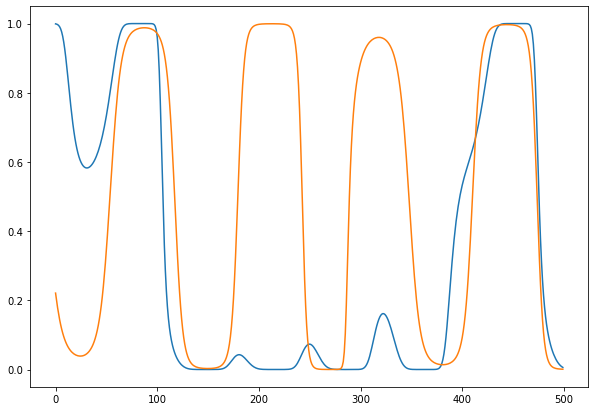

In [231]:
plt.plot(r_L[:500, 0])
plt.plot(r_R[:500, 0])

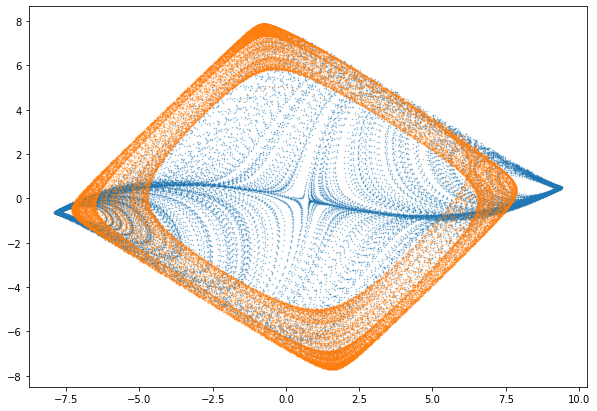

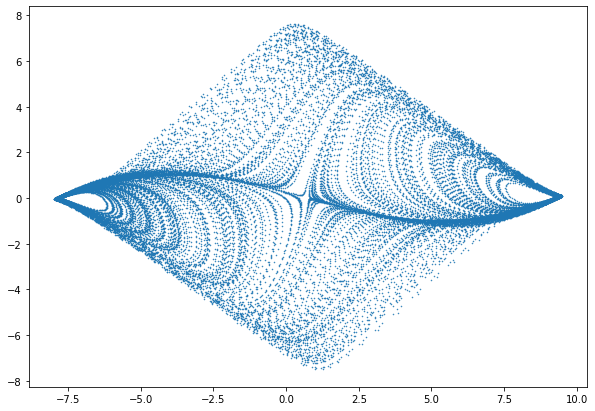

In [205]:
# Lorenz:
pca = decomposition.PCA(n_components=2)
pca.fit(r_L)
X = pca.transform(r_L)
plt.scatter(X[:, 0], X[:, 1], s=0.25)

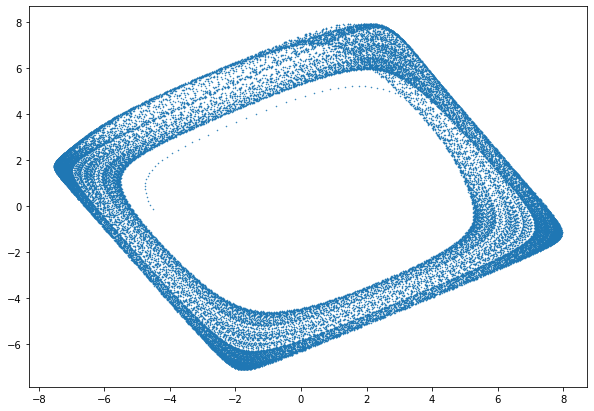

In [206]:
# Lorenz:
pca = decomposition.PCA(n_components=2)
pca.fit(r_R)
X = pca.transform(r_R)
plt.scatter(X[:, 0], X[:, 1], s=0.25)

# Kernel PCA:

In [210]:
R_reduced = np.concatenate((r_L[: 10000, :], r_R[: 10000, :]))

In [211]:
kernel_pca = decomposition.KernelPCA(
    n_components=2, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_kernel_pca = kernel_pca.fit(R_reduced).transform(R_reduced)

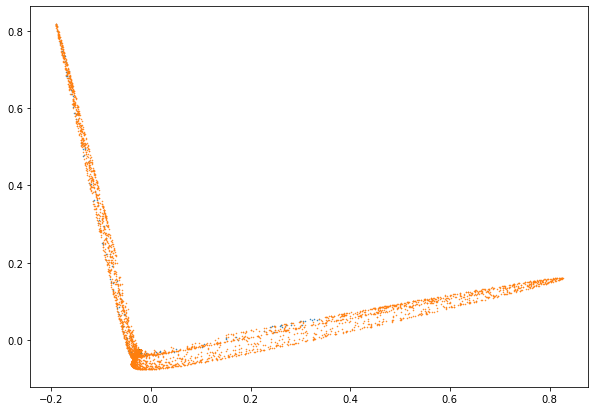

In [212]:
plt.scatter(X_test_kernel_pca[:500, 0], X_test_kernel_pca[:500, 1], s=0.25)
plt.scatter(X_test_kernel_pca[500:, 0], X_test_kernel_pca[500:, 1], s=0.25)

## Attractor measures:

### Probability Density Function:

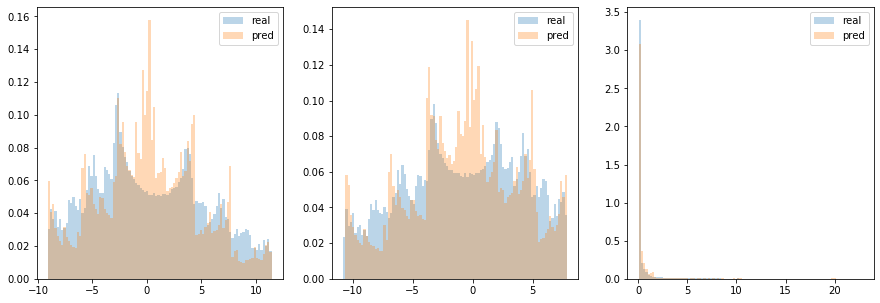

In [101]:
# Roessler:
y_test = y_test_R0
y_pred = y_pred_R
dens = True

# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real", density=dens)
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred", density=dens)
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real", density=dens)
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred", density=dens)
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real", density=dens)
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred", density=dens)
plt.legend()

### Fourier Spectrum:

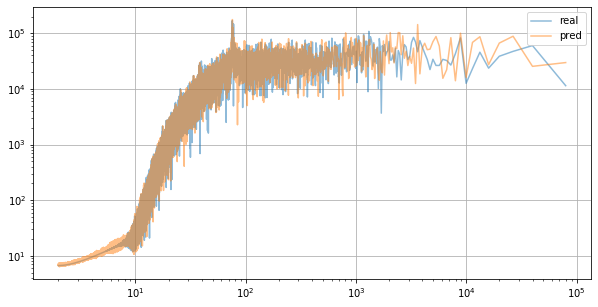

In [9]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

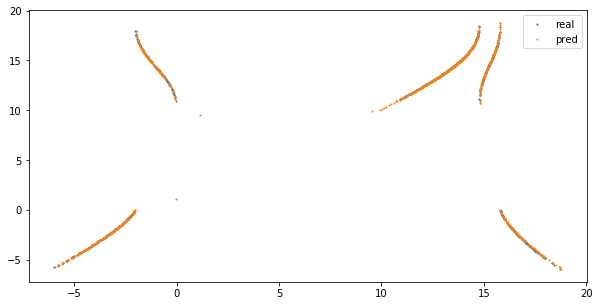

In [10]:
# Poincare Map:
ix = 0
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

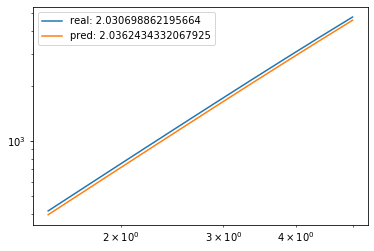

In [11]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

avg period: 3.628044383186562
For 0/79700 points, all 50 closest neighbours were temporally closer than 3.628044383186562 and thus not considered
For 888/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78812
avg period: 4.260265365622095
For 0/79700 points, all 50 closest neighbours were temporally closer than 4.260265365622095 and thus not considered
For 1095/79700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 78605


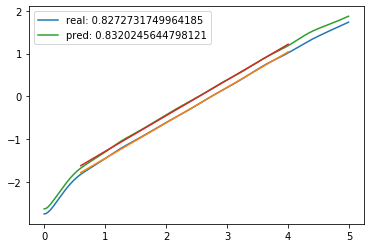

In [12]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

#### QR decomposition:

In [202]:
Nens = 5
N_dims = 5
np.random.seed(42)
starting_points = np.random.randn(Nens, 3)

In [14]:
# iterator of reservoir:
def f_res(x):
    return esn._predict_step(x)

In [204]:
out_real = rescomp.measures.calculate_divergence(f_L, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

out_res = rescomp.measures.calculate_divergence(f_res, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000
N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000


(0, 1)

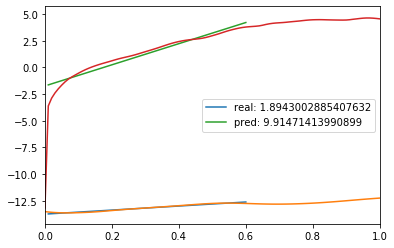

In [206]:
for out, label in zip((out_real, out_res), ("real", "pred")):
    y = np.log(out)
    y = np.mean(y, axis=-1)[:, 0]
    t = np.arange(0, y.size)*dt_L
    x_fit, y_fit, coef = rescomp.utilities._linear_fit(y, dt_L, t_min=0.01, t_max=0.6)
    plt.plot(x_fit, y_fit, label=f"{label}: {coef[0]}")
    plt.plot(t, y)
plt.legend()
plt.xlim(0, 1)

## Different inputs and synchronization:

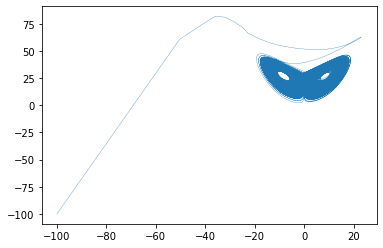

In [15]:
starting_point = np.array([-100, -100, -100])

# test lorenz iterator:
time_steps = 100000

time_series_2 = np.zeros((time_steps, 3))
time_series_2[0, :] = starting_point

res_results = np.zeros((time_steps, 500))

for i in range(1, time_steps):
    x_last = time_series_2[i - 1, :]
    time_series_2[i, :] = f_res(x_last)
    res_results[i, :] = esn._last_r

plt.plot(time_series_2[:, 0], time_series_2[:, 2], linewidth=0.3)

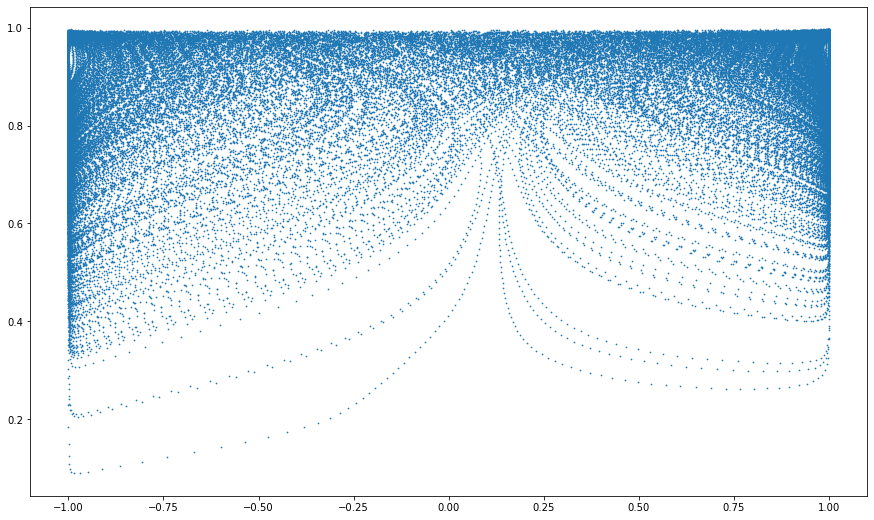

In [25]:
plt.figure(figsize=(15, 9))
# plt.plot(res_results[:, 5])
# plt.plot(res_results[1000:-1000, 50], res_results[1000:-1000, 76], linewidth=0.3)
plt.scatter(res_results[1000:-1000, 53], res_results[1000:-1000, 52], s=0.5)

### PCA on reservoir states:

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(res_results)
X = pca.transform(res_results)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.89430941 0.09141061 0.00928027]
[4661.74817278 1490.4013046   474.88143114]


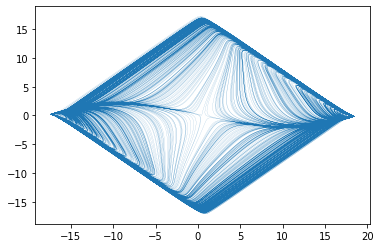

In [29]:
plt.plot(X[1000:, 0], X[1000:, 1], linewidth=0.1)

In [ ]:
# sloap, N_r = rescomp.measures.dimension(X[1000:, :], return_neighbours=True, nr_steps=10)
sloap, N_r = rescomp.measures.dimension(res_results, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

plt.legend()

# Lorenz 96 Iterator:

### Plotting the pure Lorenz 96 system

In [13]:
# Lorenz 96 parameters:
dt_L96 = 0.01
dims_L96 = 60
np.random.seed(1)
starting_point_L96 = np.random.randn(dims_L96)

In [14]:
# Lorenz96 iterator:

_lorenz_96 = rescomp.simulations._lorenz_96
iterator = rescomp.simulations._runge_kutta
f_L96 = lambda x: iterator(_lorenz_96, dt_L96, x)

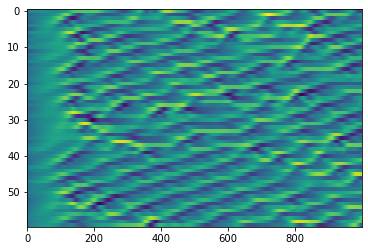

In [15]:
time_steps_L96 = 1000
results_L96 = np.zeros((time_steps_L96, dims_L96))

results_L96[0, :] = starting_point_L96
for i in range(1, time_steps_L96):
    x_last = results_L96[i - 1, :]
    results_L96[i, :] = f_L96(x_last)

plt.imshow(results_L96.T, aspect="auto")

# Reservoir:

In [180]:
import tensorflow as tf
from keras.layers import AveragePooling1D, Conv1D, InputLayer
from keras.models import Sequential
import networkx as nx

np.random.seed(2)

# Parameters:
time_steps = 10000
disc_timesteps = 100

# reservoir:
dims = [1000, 800, 500]
convs = [dims_L96, int(dims_L96 / 2), int(dims_L96/4)]
print(convs)

model1 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=1, strides=1, padding='same')
])
def f1(x):
    return model1.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96))

model2 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=2, strides=2, padding='same')
])
def f2(x):
    return model2.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/2))

model3 = Sequential(
[
    InputLayer(input_shape=(dims_L96,1)),
    AveragePooling1D(pool_size=4, strides=4, padding='same')
])
def f3(x):
    return model3.predict(x.reshape(1, dims_L96, 1)).reshape(int(dims_L96/4))

pools = [f1, f2, f3]

w_in_scale = 0.5
w_ins = []
for i in range(3):
    w_in = np.random.uniform(low=-w_in_scale,
                             high=w_in_scale,
                             size=(dims[i], convs[i]))
    w_ins.append(w_in)

edge_prob = 0.01
Ws = []
for i in range(3):
    W = nx.to_numpy_array(nx.fast_gnp_random_graph(dims[i], edge_prob,seed=np.random))
    Ws.append(W)

res_states = []
for i in range(3):
    res_state = np.zeros((time_steps, dims[i]))
    res_state[0, :] = np.random.randn(dims[i])
    res_states.append(res_state)

[60, 30, 15]


In [181]:
starting_point_L96_use = starting_point_L96
starting_point_L_use = starting_point_L

# discard the starting timesteps:
for i in range(disc_timesteps):
    starting_point_L96_use = f_L96(starting_point_L96_use)
    starting_point_L_use = f_L(starting_point_L_use)

In [182]:
# L96
results_L96 = np.zeros((time_steps, dims_L96))
results_L96[0, :] = starting_point_L96_use

# L:
results_L = np.zeros((time_steps, 3))
results_L[0, :] = starting_point_L_use

##  Run RC:

In [183]:
# f = lambda x: np.tanh(x)
# f = lambda x: 0.1*x
# f = lambda x: np.heaviside(x,1)
f = lambda x: 1/(1+np.exp(-x))

for i in range(1, time_steps):
    x_last_in = results_L96[i - 1, :]

    x_last_res1 = res_states[0][i - 1, :]
    x_last_res2 = res_states[1][i - 1, :]
    x_last_res3 = res_states[2][i - 1, :]

    for k in range(3):
        x_last_res =  res_states[k][i - 1, :]

        # apply pooling:
        x_last_in_pool = pools[k](x_last_in)
        # print(x_last_in_pool.shape)
        # print(w_ins[k].shape)
        # coupl pooled input with reservoir
        inp =  w_ins[k].dot(x_last_in_pool) + Ws[k].dot(x_last_res)
        res_states[k][i, :] = f(inp)
    results_L96[i, :] = f_L96(x_last_in)

## Plot Reservoir quantities:

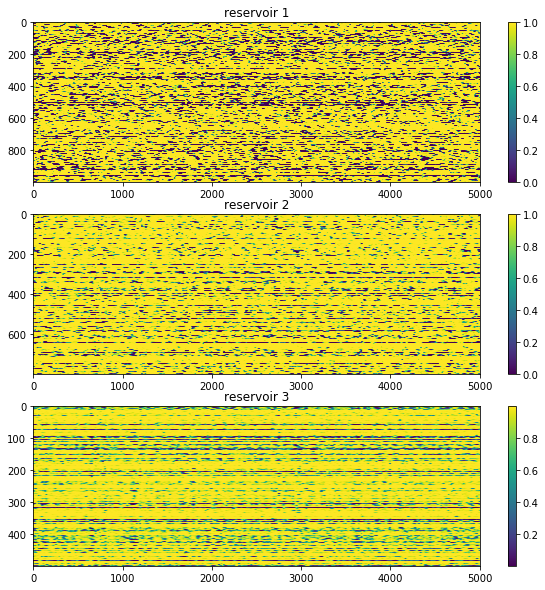

In [184]:
xlim = (0,5000)
# xlim = None

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

for k in range(3):
    ax = axs[k]
    im = ax.imshow(res_states[k][1:, :].T, aspect="auto")
    ax.set_xlim(xlim)
    ax.set_title(f"reservoir {k+1}")
    fig.colorbar(im, ax=ax, orientation='vertical')

(0, 0.1)

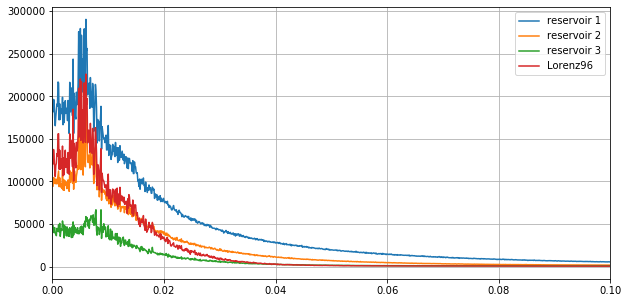

In [185]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for k in range(3):
    x, y = rescomp.measures.fourier_spectrum(res_states[k])
    ax.plot(x, y, label=f"reservoir {k+1}")


x, y = rescomp.measures.fourier_spectrum(results_L96)
ax.plot(x, y, label="Lorenz96")

ax.grid()
ax.legend()
ax.set_xlim(0, 0.1)

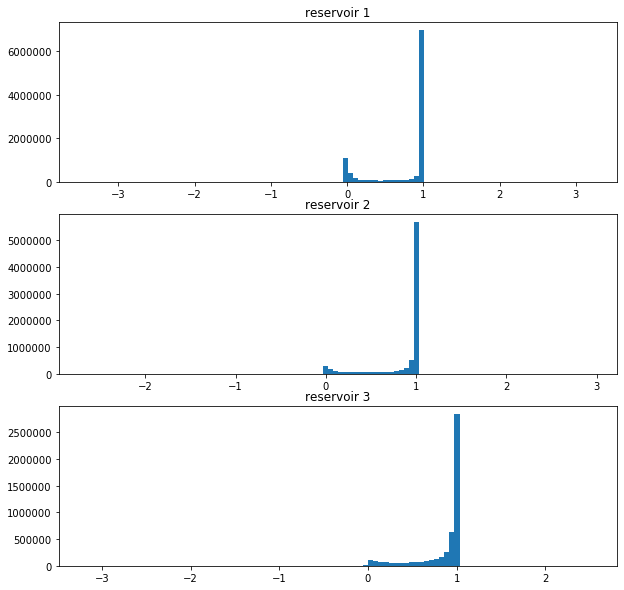

In [186]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for k in range(3):
    ax = axs[k]
    ax.hist(res_states[k].flatten(), bins=100)
    ax.set_title(f"reservoir {k+1}")

## Train and Test:

In [187]:
from sklearn.linear_model import Ridge, LogisticRegression
# Try to fit the coupled to the output:
sync_steps = 500
train_steps = 8000
test_steps = 1500


y_sync = results_L96[: sync_steps, :]

y_train = results_L96[sync_steps: sync_steps + train_steps, :]

y_test = results_L96[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]

y_test_pred_list = []

for k in range(3):
    x_sync = res_states[k][: sync_steps, :]
    x_train = res_states[k][sync_steps: sync_steps + train_steps, :]
    x_test = res_states[k][sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
    # Train:
    model = Ridge(alpha=0.005)
    model.fit(x_train, y_train)

    y_test_pred = model.predict(x_test)
    y_test_pred_list.append(y_test_pred)

all_together = np.concatenate(res_states, axis=-1)
x_sync = all_together[: sync_steps, :]
x_train = all_together[sync_steps: sync_steps + train_steps, :]
x_test = all_together[sync_steps + train_steps: sync_steps + train_steps + test_steps, :]
# Train:
model = Ridge(alpha=0.005)
model.fit(x_train, y_train)

y_test_pred = model.predict(x_test)
y_test_pred_list.append(y_test_pred)

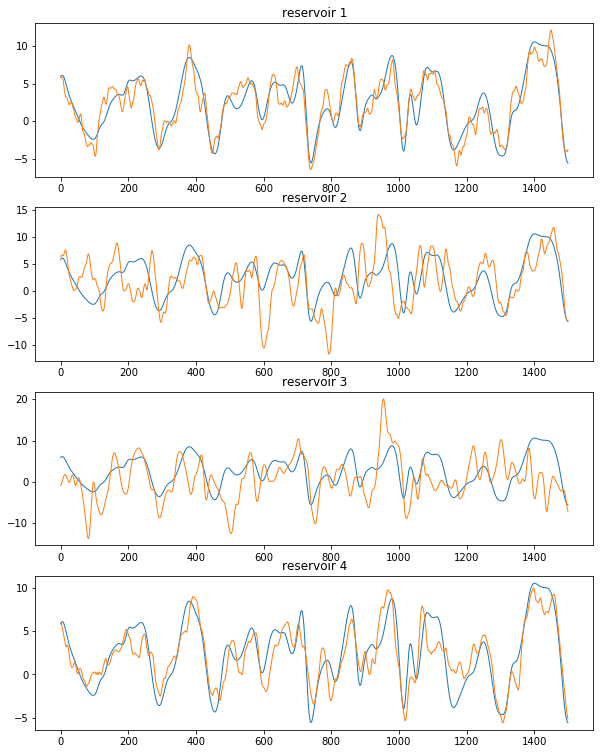

In [188]:
axis = 5

fig, axs = plt.subplots(4, 1, figsize=(10, 13))
for k in range(4):
    y_test_pred = y_test_pred_list[k]
    ax = axs[k]
    ax.plot(y_test[:, axis], linewidth=1)
    ax.plot(y_test_pred[:, axis], linewidth=1)
    ax.set_title(f"reservoir {k+1}")
